# **IMPORTS**

In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import tensorflow.keras.datasets.mnist as mnist
from torch.utils.data import Dataset , DataLoader
import random
import os
from torchvision import datasets, models, transforms
from tqdm import tqdm
import glob
import albumentations as A
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from torch.autograd import Variable


%matplotlib inline

In [2]:
import os
from tqdm import tqdm

# Data Processing Libraries 

import pandas as pd 
import numpy as np 


# Feature Engineering Libraries

from sklearn.preprocessing import OneHotEncoder

# Data Visualisation libraries 
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

## Image Augmentation 

# skimage
from skimage.io import imshow, imread, imsave
from skimage.transform import rotate, AffineTransform, warp,rescale, resize, downscale_local_mean
from skimage import color,data
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from sklearn.preprocessing import MultiLabelBinarizer

# 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from torch.utils.data import Dataset , DataLoader

#OpenCV-Python
import cv2

# imgaug
import imageio
import imgaug as ia
import imgaug.augmenters as iaa

# Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
SAMPLE_LEN=100

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
!pip install torchmetrics
import torchmetrics 

# Paths and read csv 

In [68]:
train_image_path = '../input/plant-pathology-2021-fgvc8/train_images'
test_image_path = '../input/plant-pathology-2021-fgvc8/test_images'
train_df_path = '../input/plant-pathology-2021-fgvc8/train.csv'
test_df_path = '../input/plant-pathology-2021-fgvc8/sample_submission.csv'
resized_path = ('../input/resized-plant2021/img_sz_256')

df_train = pd.read_csv(train_df_path)
df_test = pd.read_csv(test_df_path)

# Exploring the data 

In [6]:
df_train.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [7]:
df_train['labels'].value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

#  *Label Distribution from train set*

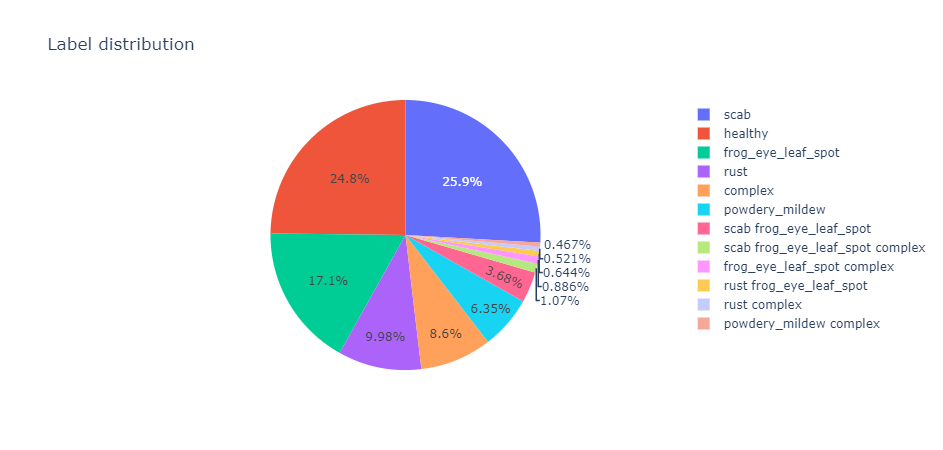

In [8]:
source = df_train['labels'].value_counts()
fig = go.Figure(data=[go.Pie(labels=source.index,values=source.values)])
fig.update_layout(title='Label distribution')
fig.show()

In [9]:
def visualize_images(path,image_ids, labels, row):
    plt.figure(figsize=(16, 12), dpi=80)
    r = int(row/4) + 1 
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(r, 4, ind + 1)
        image = cv2.imread(os.path.join(path, image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    plt.show()
    

# Showing images of data with label 

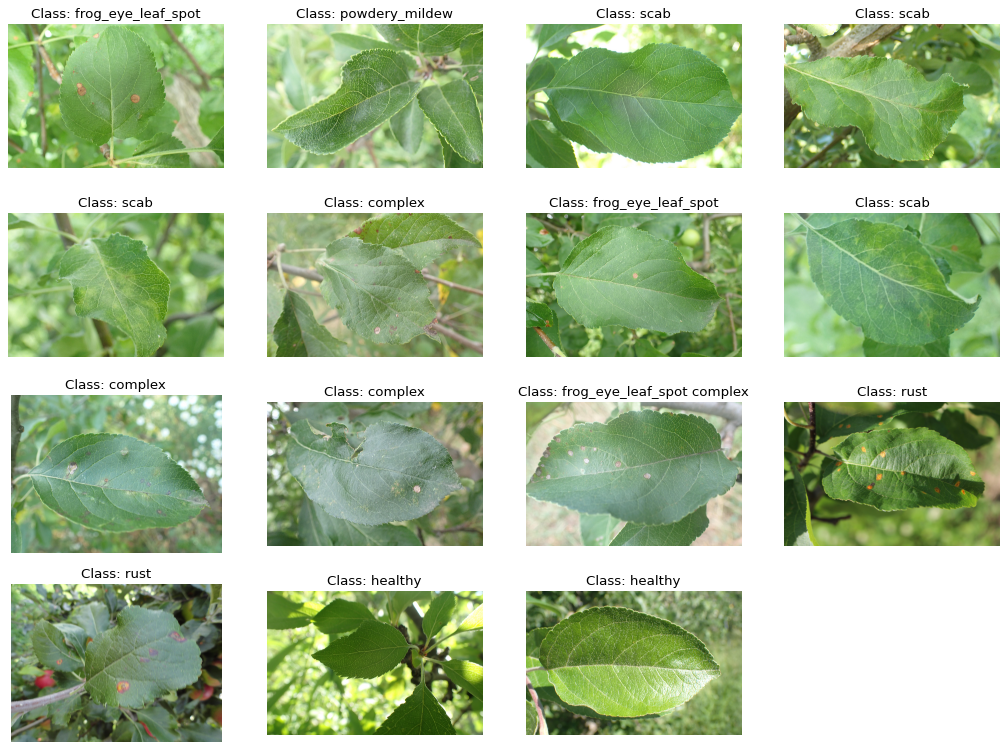

In [69]:
row = 15 
tmp_df = df_train.sample(row)
image_ids = tmp_df["image"].values
labels = tmp_df["labels"].values
visualize_images(train_image_path,image_ids,labels, row)

# Train set data loader

In [13]:
transform = A.Compose([A.HorizontalFlip(),A.RandomBrightness(0.6),ToTensorV2()
])

class My_Train_Dataset(Dataset):
    def __init__(self, paths, transform=None, train=True, size=224):
        self.paths = paths
        self.transform = transform
        self.train = train
        self.size = size
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        p = self.paths[idx]
        #label = train_labels.get(p)
        #int_label = label_str2num.get(label)
        int_label = train_targets[idx]

        image = cv2.imread(os.path.join(resized_path, p))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.size, self.size))
       
        if self.transform:
          image = self.transform(image = image)["image"]

        return image, int_label

# Test set data loader

In [14]:
transformV = A.Compose([ToTensorV2()
])

class My_Test_Dataset(Dataset):
    def __init__(self, paths, transform=None, test=False, size=224):
        self.paths = paths
        self.transform = transform
        self.test = test
        self.size = size
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        p = self.paths[idx]
        #label = val_labels.get(p) #string label 
        #int_label = label_str2num.get(label)
        int_label = val_targets[idx]
        
        if self.test == True :
            image = cv2.imread(os.path.join(test_image_path, p))
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.size, self.size)) 
            
            return image
            
        else :
                image = cv2.imread(os.path.join(resized_path, p))
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (self.size, self.size)) 
            

        if self.transform:
          image = self.transform(image = image)["image"]

        return image, int_label 

# Converting the predictions to string 

In [12]:
  label_num2str = {0: 'complex',
                     1: 'frog_eye_leaf_spot',
                     2: 'healthy',
                     3: 'powdery_mildew',
                     4: 'rust',
                  5: 'scab'}
label_str2num = {'complex': 0,
                     'frog_eye_leaf_spot': 1,
                     'healthy': 2,
                     'powdery_mildew': 3,
                     'rust': 4,
                     'scab':5}

# Functions

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [33]:
DEBUG = False 
def train(train_loader, model, optimizer, epoch, criterion, model_name):
    accuracy = AverageMeter()
    losses = AverageMeter()
    model.train()

    for i, (img, target) in tqdm(enumerate(train_loader)):
        img = img.float()    
        target = target.float()

        img = img.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(img)

        if DEBUG:
            print('output',output.detach().cpu().numpy(),
                    'shape', output.detach().cpu().numpy().shape )

            print('target',target.detach().cpu().numpy(),
                    'shape', target.detach().cpu().numpy().shape )

        loss = criterion(output, target)
        loss.backward()

        optimizer.step()
    

        #pred = output.argmax(dim=1 , keepdim=True)
        activation = nn.Sigmoid()
        pred = activation(output)
        sum = 0 
        for i in range(6):
            sum += pred[0][i]
        th = (sum/6) - 0.1 
        for i in range(6):
            if pred[0][i] > th :
                pred[0][i] = 1
            else :
                pred[0][i] = 0
       # print(target)
       # print(pred)
        

        acc = torchmetrics.functional.accuracy(pred, target.int())

        losses.update(loss.item(), img.size(0))
        accuracy.update(acc, img.size(0))
   # writer.add_scalar(model_name +' average training loss', losses.avg,  i*epoch)
    #writer.add_scalar(model_name +' average training accuracy', accuracy.avg*100,  i*epoch)
       # print(' average training loss', losses.avg,  i)
        #print(' average training accuracy', accuracy.avg*100,  i)
    print(f': Training : Average Accuracy per batch = { acc * 100} , Average Loss per batch {losses.avg}')

    return losses.avg, accuracy.avg*100


In [16]:
best_acc = 80
def validate(dataloader, model, criterion, optimizer, epoch, model_name):
  acc = AverageMeter()
  losses = AverageMeter()
  model.eval()
  loss_accumlated = 0
  for i, (x_batch, y_batch) in tqdm(enumerate(dataloader)):
    x_batch = x_batch.float()
    x_batch = x_batch.to(device)
    y_batch = y_batch.float()
    y_batch = y_batch.to(device)
    optimizer.zero_grad() 
    output = model(x_batch) 
    loss = criterion(output, y_batch)
    
    losses.update(loss.item(), x_batch.size(0))
    loss_accumlated += loss.item()
    activation = nn.Sigmoid()
    pred = activation(output)
    sum = 0 
    for i in range(6):
        sum += pred[0][i]
    th = (sum/6) - 0.1 
    for i in range(6):
        if pred[0][i] > th :
            pred[0][i] = 1    
        else :
            pred[0][i] = 0
        
        
    accuracy = torchmetrics.functional.accuracy(pred, y_batch.long())
    acc.update(accuracy, x_batch.size(0))

  #writer.add_scalar(model_name + ' average validation loss', losses.avg,  i*epoch)
  #writer.add_scalar(model_name + ' average validation accuracy', acc.avg*100,  i*epoch)
  global best_acc
  if (best_acc < acc.avg*100):
    #save_model(model, criterion, epoch, losses.avg, "../input/plant-pathology-2021-fgvc8/train_images"+model_name)
    best_acc = acc.avg*100
    print("found new best model")
    print(f': Validation : Average Accuracy per batch = { acc.avg*100} , Average Loss per batch {losses.avg}')
  else: 
        print(f': Validation : Average Accuracy per batch = { acc.avg*100} , Average Loss per batch {losses.avg}')
  return losses.avg, acc.avg*100

In [17]:
def results_gragh(losses_train, acc_train, losses_val, acc_val):
  plt.figure(figsize=(12, 20), dpi=60)
  plt.subplot(4,2, 1)
  plt.title('Loss on Train', fontsize=30)
  plt.plot(losses_train)

  plt.subplot(4,2,2)
  plt.title('Auccuracy on Train', fontsize=30)
  plt.plot(acc_train)


  plt.subplot(4,2, 3)
  plt.title('Loss on Val', fontsize=30)
  plt.plot(losses_val)

  plt.subplot(4,2,4)
  plt.title('Auccuracy on Val', fontsize=30)
  plt.plot(acc_val)

In [18]:
def training_Model(model, loader_train, loader_val, criterion,opt,model_name):
  losses_train = []
  acc_train = []
  losses_val = []
  acc_val = []
  EPOCHS = 10
  for e in range(EPOCHS):
    print(f'Epoch {e+1}')
    result_train = train(loader_train, model = model , criterion=criterion, optimizer=opt, epoch=e, model_name= model_name)
    result_val = validate(loader_val, model, criterion, opt, e, model_name= model_name)
    losses_train.append(result_train[0])
    acc_train.append(result_train[1])
    losses_val.append(result_val[0])
    acc_val.append(result_val[1])
  return losses_train, acc_train, losses_val, acc_val

In [19]:
def set_parameter_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

# Pre processing the data 

In [20]:
df = df_train

In [21]:
train_size = int(0.8 * len(df_train))
val_size = int(0.2 * len(df_train))  

# one hot encoded labels with MultiLabelBinarizer
## sending as target vector of 0 and 1 according to the labels

## for example 'healthy' = [0, 0, 1, 0, 0, 0]
## *In the train and validate functions the preds are also a vector of 0 and 1 according to mean threshold of the specific label , sum all the probabiltis from the pred vector and calcuate the mean value so each probabilty that is bigger than the mean value is 1 , smaller is 0*  

In [22]:
df['labels']=df['labels'].apply( lambda string: string.split(' ') )
df.head()

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
hot_labels = mlb.fit_transform(df['labels'])
print(mlb.classes_)
print(hot_labels)

['complex' 'frog_eye_leaf_spot' 'healthy' 'powdery_mildew' 'rust' 'scab']
[[0 0 1 0 0 0]
 [1 1 0 0 0 1]
 [0 0 0 0 0 1]
 ...
 [0 0 0 0 1 0]
 [0 1 0 0 0 1]
 [0 0 1 0 0 0]]


In [23]:
hot_labels = torch.tensor(hot_labels)
train_targets = torch.empty(train_size, 6, dtype=torch.int)
val_targets = torch.empty(val_size, 6, dtype=torch.int)
for i in range(train_size):
     train_targets[i] = hot_labels[i] 
for i in range(val_size):
    val_targets[i] = hot_labels[i + train_size] 
    

In [24]:
len(train_targets)

14905

In [25]:
len(val_targets)

3726

In [26]:
train_ = []
val_ = []
for i in range(train_size):
    train_.append(df_train['image'][i])
for i in range(val_size):
    val_.append(df_train['image'][i + train_size])

In [27]:
len(train_)

14905

In [28]:
len(val_)

3726

# Defining the model 
## Resnet 50 Model from models.resnet50
## Using criterion as BCEWithLogitLoss and 
## the optimizer is optim.Adam with lr = 0.001

In [29]:
model_ft = models.resnet50()
model_ft.load_state_dict(torch.load('../input/model-resnet/resnet50/resnet50-19c8e357.pth'))
set_parameter_requires_grad(model_ft, False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 6)
model_ft = model_ft.to(device)
criterion1 = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
criterion1 = nn.BCELoss()
input_size = 224

In [30]:
data_train = My_Train_Dataset(train_,transform) 
data_test = My_Test_Dataset(val_, transformV, test = False)

In [31]:
BS=32
loader_train = DataLoader(dataset= data_train, batch_size= BS, shuffle=True, num_workers=2 )
loader_val = DataLoader(dataset= data_test, batch_size= BS, shuffle=False, num_workers=2)
dataloaders = {"train" : loader_train, "val" : loader_val}
opt = torch.optim.Adam(model_ft.parameters(), lr = 0.001)
opt1 = optim.SGD(model_ft.parameters(), lr = 0.0001, momentum=0.9)
#opt_vgg11 = optim.Adam(model_vgg11.parameters(), lr = 0.001)

In [34]:
losses_train, acc_train, losses_val, acc_val = training_Model(model_ft, loader_train, loader_val, criterion, opt, 'resnet')

Epoch 1


466it [01:53,  4.11it/s]

: Training : Average Accuracy per batch = 92.0 , Average Loss per batch 0.2130834469776032



117it [00:15,  7.74it/s]

found new best model
: Validation : Average Accuracy per batch = 93.57219696044922 , Average Loss per batch 0.15629354634802634
Epoch 2



466it [01:53,  4.11it/s]

: Training : Average Accuracy per batch = 91.33333587646484 , Average Loss per batch 0.19410828823453025



117it [00:09, 12.58it/s]

: Validation : Average Accuracy per batch = 93.17857360839844 , Average Loss per batch 0.16631630761723842
Epoch 3



466it [01:53,  4.10it/s]

: Training : Average Accuracy per batch = 95.33332824707031 , Average Loss per batch 0.17987789528876172



117it [00:09, 12.58it/s]

: Validation : Average Accuracy per batch = 92.14080810546875 , Average Loss per batch 0.19839196379026033
Epoch 4



466it [01:53,  4.11it/s]

: Training : Average Accuracy per batch = 96.0 , Average Loss per batch 0.17200349770168938



117it [00:10, 11.68it/s]

: Validation : Average Accuracy per batch = 90.57524108886719 , Average Loss per batch 0.26827717108139093
Epoch 5



466it [01:53,  4.12it/s]

: Training : Average Accuracy per batch = 93.33333587646484 , Average Loss per batch 0.16487932777352798



117it [00:10, 11.65it/s]

: Validation : Average Accuracy per batch = 92.88333892822266 , Average Loss per batch 0.18026253045948998
Epoch 6



466it [01:53,  4.12it/s]

: Training : Average Accuracy per batch = 93.33333587646484 , Average Loss per batch 0.15635877811780755



117it [00:09, 12.97it/s]

found new best model
: Validation : Average Accuracy per batch = 93.63034057617188 , Average Loss per batch 0.15444337394262472
Epoch 7



466it [01:53,  4.11it/s]

: Training : Average Accuracy per batch = 93.33333587646484 , Average Loss per batch 0.15015366515310288



117it [00:09, 12.13it/s]

found new best model
: Validation : Average Accuracy per batch = 94.52941131591797 , Average Loss per batch 0.14058266583704143
Epoch 8



466it [01:52,  4.13it/s]

: Training : Average Accuracy per batch = 96.66666412353516 , Average Loss per batch 0.14493116044790222



117it [00:10, 11.63it/s]

: Validation : Average Accuracy per batch = 91.91266632080078 , Average Loss per batch 0.19844327047187285
Epoch 9



466it [01:53,  4.12it/s]

: Training : Average Accuracy per batch = 94.0 , Average Loss per batch 0.13859316671166552



117it [00:09, 12.03it/s]

: Validation : Average Accuracy per batch = 93.46482849121094 , Average Loss per batch 0.15898410991530104
Epoch 10



466it [01:52,  4.13it/s]

: Training : Average Accuracy per batch = 95.33332824707031 , Average Loss per batch 0.13421494824320068



117it [00:09, 12.25it/s]

: Validation : Average Accuracy per batch = 94.31027221679688 , Average Loss per batch 0.14919421419909226


# Graghs of loss and accuracy

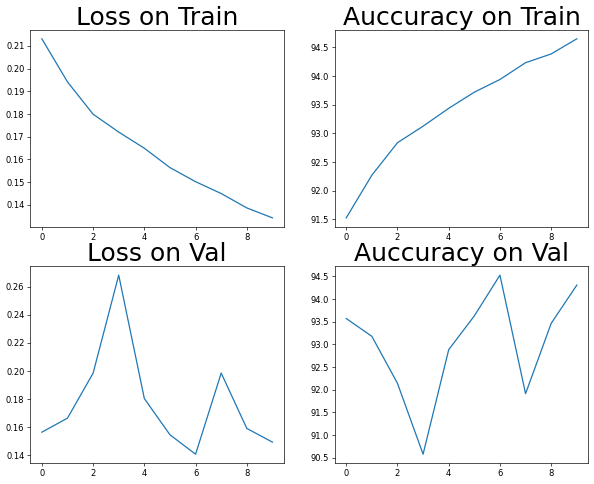

In [35]:
results_gragh(losses_train, acc_train, losses_val, acc_val)

# It seems the model learned really good training acc : 95 validation acc : 94

## Reading the test data frame

In [37]:
test_image_path = '../input/plant-pathology-2021-fgvc8/test_images'
df_test = pd.read_csv(test_df_path)
df_test

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [38]:
for i in range (3):
    df_test['labels'][i] = 'none'

In [39]:
test_ = []
for i in range(3):
    test_.append(df_test['image'][i])
    
    
test_

['85f8cb619c66b863.jpg', 'ad8770db05586b59.jpg', 'c7b03e718489f3ca.jpg']

In [40]:
submit_df =   df_test
submit_df

,image,labels
0,85f8cb619c66b863.jpg,none
1,ad8770db05586b59.jpg,none
2,c7b03e718489f3ca.jpg,none


# loading the images with test data loader

In [41]:
data_test = My_Test_Dataset(test_, transformV, test = True)
testloader = DataLoader(dataset= data_test, batch_size= 16, shuffle=False)

In [42]:
def input_p(img):
    img = img.float()   
    img = img[None, ...]
    img = img.permute(0,3,2,1)
    img = img.to(device)
    return img 

In [57]:
def prediction(img , model):
    output = model_ft(img)
    #print(preds)
    activation = nn.Sigmoid()
    pred = activation(output)
    sum = 0 
    for i in range(6):
        sum += pred[0][i]
    th = (sum/6) - 0.1 
    for i in range(6):
        if pred[0][i] > 0.4 :
            pred[0][i] = 1    
        else :
            pred[0][i] = 0
    pred = pred.tolist()
    res = []
    for p in pred:
        temp = []
        for i, category in enumerate(p):
            if category == 1:
                temp.append(i)
        if temp!=[]:
            res.append(temp)
        else:
            temp.append(np.argmax(pred))
            res.append(temp)
    s = np.str()       
    for i in res[0]:
         s = s+' '+ (label_num2str.get(i))

    return s

In [60]:
for i, (im1, im2, im3) in tqdm(enumerate(testloader)):
    im1 = input_p(im1)
    im2 = input_p(im2)    
    im3 = input_p(im3)
    prediction1 = prediction(im1, model_ft)
    prediction2 = prediction(im2, model_ft)    
    prediction3 = prediction(im3, model_ft)

1it [00:00,  1.65it/s]


# PREDICT AND SUBMIT  

In [61]:
submit_df['labels'][0] = prediction1
submit_df['labels'][1] = prediction2
submit_df['labels'][2] = prediction3
submit_df.to_csv('submission.csv', index=False)
submit_df

,image,labels
0,85f8cb619c66b863.jpg,complex rust
1,ad8770db05586b59.jpg,complex
2,c7b03e718489f3ca.jpg,frog_eye_leaf_spot rust


# Notebook I understood the data better 
link for the notebook https://www.kaggle.com/praveengovi/plant-pathology-detail-eda-pytorch

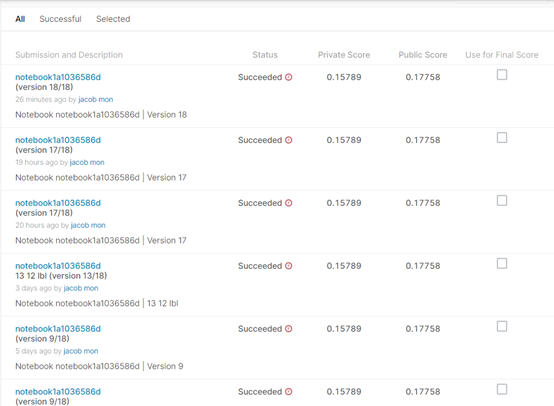